# Method 2: Machine Learning with Google BERT 

In [20]:
import numpy as np 
import pandas as pd 
import random
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [2]:
dataset = pd.read_csv("IMDB Dataset.csv")
# Please note that this approach is very time consuming because my mac doesn't suppoprt 
# GPU version of Pytorch, thus we only take 1000 review in this project to train and test the model.
dataset = dataset.iloc[0:1000]
train, test = train_test_split(dataset, test_size=0.25)
train.head()

,review,sentiment
82,"Oh God, I must have seen this when I was only ...",negative
991,I dunno sometimes...you try and try and try to...,negative
789,This little two-person movie is actually much ...,positive
894,After several extremely well ratings to the po...,positive
398,"After a snowstorm, the roads are blocked and t...",negative


# Step 1: 
## Pre-processing a): get text values and labels and load the pretrained Tokenizer

In [3]:
# Get text values and labels
text_values = train.review.values
labels = train.sentiment.replace({'positive': 1, 'negative': 0}).values
# Load the pretrained Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [4]:
print('Original Text : ', text_values[1])
print('Tokenized Text: ', tokenizer.tokenize(text_values[1]))
print('Token IDs     : ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_values[1])))

Original Text :  I dunno sometimes...you try and try and try to be charitable towards all the B thru Z grade movies out there, but once in a while a particular movie just tests your patience until you want to slap everyone involved. "Bat People" (which I saw under the title "It Lives By Night") is just such a movie. You can't watch this without thinking that it really should have been an episode on "Night Gallery", and not one of the better ones, either. <br /><br />The movie has something to do with a doctor who gets bitten by a bat and consequently starts to morph into a Were-Bat who drinks human blood. (Actually, you'd think if he was turning into a real bat, he'd be eating mosquitoes by the gallon bucket, but because this is a cheap, lurid horror movie, blood's the word.) In spite of the fact that he has grand-mal seizures at the drop of a hat, and black-out episodes almost every night, his friend and fellow physician, Dr. Mustache Aspen-Extreme, insists that he's just having an 'a

## Pre-processing b): prepare the class, seperation and padding tokens

In [5]:
text = '[CLS]'
print('Original Text : ', text)
print('Tokenized Text: ', tokenizer.tokenize(text))
print('Token IDs     : ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text)))
print('\n')

text = '[SEP]'
print('Original Text : ', text)
print('Tokenized Text: ', tokenizer.tokenize(text))
print('Token IDs     : ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text)))
print('\n')

text = '[PAD]'
print('Original Text : ', text)
print('Tokenized Text: ', tokenizer.tokenize(text))
print('Token IDs     : ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text)))

Original Text :  [CLS]
Tokenized Text:  ['[CLS]']
Token IDs     :  [101]


Original Text :  [SEP]
Tokenized Text:  ['[SEP]']
Token IDs     :  [102]


Original Text :  [PAD]
Tokenized Text:  ['[PAD]']
Token IDs     :  [0]


In [6]:
print('Original Text                          : ', text_values[1])
print('Tokenized Text                         : ', tokenizer.tokenize(text_values[1]))
print('Token IDs                              : ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_values[1])))
print('Adding Special Tokens                  :', tokenizer.build_inputs_with_special_tokens(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_values[1]))))
print('Adding Special Tokens Using Encode Func:', tokenizer.encode(text_values[1]))

Token indices sequence length is longer than the specified maximum sequence length for this model (726 > 512). Running this sequence through the model will result in indexing errors


Original Text                          :  I dunno sometimes...you try and try and try to be charitable towards all the B thru Z grade movies out there, but once in a while a particular movie just tests your patience until you want to slap everyone involved. "Bat People" (which I saw under the title "It Lives By Night") is just such a movie. You can't watch this without thinking that it really should have been an episode on "Night Gallery", and not one of the better ones, either. <br /><br />The movie has something to do with a doctor who gets bitten by a bat and consequently starts to morph into a Were-Bat who drinks human blood. (Actually, you'd think if he was turning into a real bat, he'd be eating mosquitoes by the gallon bucket, but because this is a cheap, lurid horror movie, blood's the word.) In spite of the fact that he has grand-mal seizures at the drop of a hat, and black-out episodes almost every night, his friend and fellow physician, Dr. Mustache Aspen-Extreme, insists th

# Pre-processing c): check the distribution of number of words of the reviews

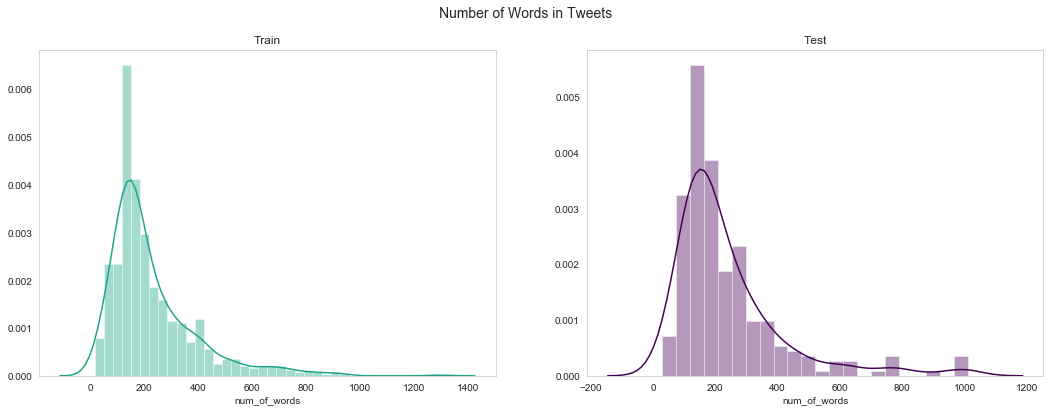

In [8]:
# Add column for number of words
train['num_of_words'] = train['review'].apply(lambda x:len(str(x).split())) 
test['num_of_words'] = test['review'].apply(lambda x:len(str(x).split())) 

# Plot
sns.set_style('whitegrid', {'axes.grid' : False})
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

sns.distplot(train['num_of_words'], color='#20A387',ax=ax[0])
sns.distplot(test['num_of_words'], color='#440154',ax=ax[1])

fig.suptitle("Number of Words in Tweets", fontsize=14)
ax[0].set_title('Train')
ax[1].set_title('Test')

plt.show()

# Step 2: encode the reviews and split the training(75%) and testing(25%) dataset

In [9]:
# Function to get token ids for a list of texts 
def encode_fn(text_list):
    all_input_ids = []    
    for text in text_values:
        input_ids = tokenizer.encode(
                        text,                      
                        add_special_tokens = True, 
                        max_length = 500,           
                        pad_to_max_length = True,
                        return_tensors = 'pt'  
                   )
        all_input_ids.append(input_ids)    
    all_input_ids = torch.cat(all_input_ids, dim=0)
    return all_input_ids

In [10]:
epochs = 4
batch_size = 32

# Split data into train and validation 
all_input_ids = encode_fn(text_values)
labels = torch.tensor(labels)

dataset = TensorDataset(all_input_ids, labels)
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create train and validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [11]:
# Load the pretrained BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False, 
)

#model.cuda()

# Create optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr = 2e-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,num_training_steps = total_steps)

# Step 3: training and validation
## Please note that in this project, because my macbook does not support GPU-version pytorch, the calculation is extremely slow. And because the number of words in the review are very big, the sequence size is set at 500, which is very big for BERT model (the max is 512). Thus, we only used 750 sample for training and 250 sample for testing. And this already took me around 8 hours :/

In [12]:
##### Training #####
for epoch in range(epochs):    
    
    model.train()   
    total_loss, total_val_loss = 0, 0   
    for step, batch in enumerate(train_dataloader):
        
        model.zero_grad()
        
        #loss, logits = model(batch[0].to(device), 
        #                     token_type_ids = None, 
        #                     attention_mask = (batch[0] > 0).to(device), 
        #                     labels = batch[1].to(device))
        loss, logits = model(batch[0], 
                             token_type_ids = None, 
                             attention_mask = batch[0] > 0, 
                             labels = batch[1])
        
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

##### Validation #####
    model.eval()
    for i, batch in enumerate(val_dataloader):
        with torch.no_grad():  
            #loss, logits = model(batch[0].to(device), 
            #                       token_type_ids = None, 
            #                       attention_mask = (batch[0] > 0).to(device),
            #                       labels = batch[1].to(device))
            loss, logits = model(batch[0], 
                                   token_type_ids = None, 
                                   attention_mask = batch[0] > 0, 
                                   labels = batch[1])
        total_val_loss += loss.item()
                    
    avg_train_loss = total_loss / len(train_dataloader)      
    avg_val_loss = total_val_loss / len(val_dataloader)     
    print('Train Loss     : ', avg_train_loss)
    print('Validation Loss: ', avg_val_loss)
    print('\n')

Train Loss     :  0.6642228002133577
Validation Loss:  0.5804982483386993


Train Loss     :  0.4493631681670313
Validation Loss:  0.40739162266254425


Train Loss     :  0.26374152237954346
Validation Loss:  0.3899597078561783


Train Loss     :  0.19965258888576343
Validation Loss:  0.3580104857683182




In [13]:
# Create the test data loader
text_values = test.review.values
all_input_ids = encode_fn(text_values)
pred_data = TensorDataset(all_input_ids)
pred_dataloader = DataLoader(pred_data, batch_size = batch_size, shuffle = False)

In [14]:
##### Predictions #####
model.eval()
preds = []
for i, (batch,) in enumerate(pred_dataloader):
    if i % 10 == 0:
        print(i)
    with torch.no_grad():
        #outputs = model(batch.to(device), 
        #                token_type_ids = None, 
        #                attention_mask = (batch > 0).to(device))
        outputs = model(batch, 
                        token_type_ids = None, 
                        attention_mask = (batch > 0))

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    preds.append(logits)
    
final_preds = np.concatenate(preds, axis=0)
final_preds = np.argmax(final_preds, axis=1)

0


In [15]:
# predicted labels
final_preds

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1])

In [16]:
# actual labels
test.sentiment.replace({'positive': 1, 'negative': 0}).values

array([1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1])

## Using only 750 samples for training, 250 for testing, with a batch size of 32 and trained 4 epoches, the testing accuracy is 90%! It is so far the best accuracy we achieved, better than any model in the previous method.

In [18]:
# Test accuracy
sum(final_preds == test.sentiment.replace({'positive': 1, 'negative': 0}).values)/len(final_preds)

0.9